In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
import PIL
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
from tensorflow.keras.applications import ResNet50,MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

!pip install -q tfa-nightly   # only nightly build supports tfa image augmentations with TPU model training
import tensorflow_addons as tfa
tfa.register_all(custom_kernels=False) # otherwise TPU throws up error

! pip install -q efficientnet
import efficientnet.tfkeras as efn

Tensorflow version 2.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Configuration

In [2]:
DEVICE = 'TPU'
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else: DEVICE = "GPU"


if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print('REPLICAS: {}'.format(REPLICAS))

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Config

In [3]:
DATA_PATH = '../input/siim-isic-melanoma-classification/'
IMAGE_PATH= DATA_PATH+'jpeg/train/'
INCLUDE_2019_DATA = True  # whether to use image of ISIC 2019 competition
INCLUDE_2018_DATA = True  # whether to use image of 2018 + 2017 competitions
INCLUDE_CD_MALIGNANT = True # include extra malignant images shared by Chris Deotte
UPSAMPLE = True             # Upsample malignant images from the current competition data only

DIM = 256  # image size to use for training, choose among 128,192,256
BATCH_SIZE = 32 * REPLICAS
EPOCHS = 20
VERBOSE = 1
TTA = 10    #  number of test-time augmentations, the same value is used for validation-time augmentation 
tf.random.set_seed(250688)
    
    
# augmentation params
MAX_ROT_ANGLE = 180.0
MAX_SHEAR_LEVEL = 0.1
HSHIFT, VSHIFT = 5., 5. # max. number of pixels to shift(translation) horizontally and vertically
MAX_ROT_ANGLE = np.pi*MAX_ROT_ANGLE/180 # in radians
AUGMENT_FRAC = 0.7 # probability that an image will go through the augmentation pipeline
NUM_CUTOUTS = 10 # how many cutouts to be inserted on each image
CUTOUT_SIZE = 15 # cutout square dimension (in number of pixels)
CUTOUT_FRAC = 0.8 # probability of cutout augmentation being applied to an image (if augmentation is turned on via AUGMENT_FRAC)

# Loss parameters
LR = 1e-3  # learning rate with Adam/RectifiedAdam
LOSS_TYPE = "FOCAL" # BCE or FOCAL
GAMMA = 2. # focal loss
ALPHA = 0.8  # focal loss

# Optimizer
OPT_TYPE = "RAdam" # "Adam" or "RAdam"

#For using TPU's, you must read data from a GCS bucket for high throughput. For using GPU's you can skip reading from GCS an.
GCS_PATH_ORG = KaggleDatasets().get_gcs_path("siim-isic-melanoma-classification")
GCS_PATH = KaggleDatasets().get_gcs_path("melanoma-{}x{}".format(DIM,DIM)) # for resized TFrecords (triple stratified)
GCS_PATH_2019 = KaggleDatasets().get_gcs_path("isic2019-{}x{}".format(DIM,DIM)) 
GCS_PATH_M = KaggleDatasets().get_gcs_path("malignant-v2-{}x{}".format(DIM,DIM))


In [4]:
# Data files access

train_files = tf.io.gfile.glob(GCS_PATH+'/train*.tfrec')
if INCLUDE_2019_DATA:
    train_files+= tf.io.gfile.glob([f"{GCS_PATH_2019}/train{(2*x +1):02d}-*.tfrec" for x in range(14)])  # odd-numbered tfrecords
if INCLUDE_2018_DATA:
    train_files+= tf.io.gfile.glob([f"{GCS_PATH_2019}/train{(2*x):02d}-*.tfrec" for x in range(15)]) # even numbered tfrecords
if INCLUDE_CD_MALIGNANT:
    new_malignant_tfrecords = np.arange(15,30).tolist()
    train_files+= tf.io.gfile.glob([f"{GCS_PATH_M}/train{x}-*.tfrec" for x in new_malignant_tfrecords])
test_files = tf.io.gfile.glob(GCS_PATH+'/test*.tfrec')

np.random.shuffle(train_files)


In [5]:
data = pd.read_csv(DATA_PATH+"train.csv")
pos = data[data.target==1].shape[0]
neg = data[data.target==0].shape[0]
total = data.shape[0]

# for setting class weights if required
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0


# Data Augmentation
- Rotate, shear, translation, cutout, crop and some colour operations.

In [6]:
RESIZE = 256


def test_aug_pipeline(img_path, rotate=True,shear=True, translate=True, colour_ops=True, cutout=True, num_cutouts=10,crop=True):
    img_raw = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(img_raw, channels=3)  #tf.io.decode_image(img_raw)
    
    image = tf.image.resize(image, [RESIZE,RESIZE])
    image = tf.cast(image, tf.float32) / 255.0
    
    image = tf.image.random_flip_left_right(image)
    if colour_ops:
        image = tf.image.random_brightness(image, max_delta= 0.05)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.random_contrast(image, 0.8, 1.2)
    
    if crop:
        tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: tf.image.central_crop(image, central_fraction= 0.7+0.3*tf.random.uniform(shape=[])), lambda : tf.image.central_crop(image,central_fraction=1.0))
        image = tf.image.resize(image, [RESIZE,RESIZE])
    
    if shear:
        image =  tfa.image.transform(image, [1.0, MAX_SHEAR_LEVEL * tf.random.uniform(shape=[],minval=-1,maxval=1), 0.0, MAX_SHEAR_LEVEL * tf.random.uniform(shape=[],minval=-1,maxval=1), 1.0, 0.0, 0.0, 0.0])

    if rotate:
        image = tfa.image.rotate(image, MAX_ROT_ANGLE * tf.random.uniform([], dtype=tf.float32)) # rotation
    if translate:
        image = tfa.image.translate(image, [HSHIFT * tf.random.uniform(shape=[],minval=-1, maxval=1), VSHIFT * tf.random.uniform(shape=[],minval=-1, maxval=1)]) # [dx dy] shift/translation
    if cutout:
        image = tfa.image.random_cutout(tf.expand_dims(image, axis=0),mask_size=10,constant_values= 0) # cutout
        for _ in range(num_cutouts-1):
               image = tfa.image.random_cutout(image,mask_size=10,constant_values= 0) # cutout
    image = tf.clip_by_value(image, 0, 1)
    _ = plt.imshow(tf.squeeze(image))
    return image


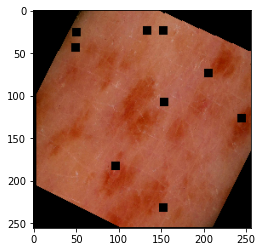

In [7]:
file = np.random.choice(tf.io.gfile.glob(GCS_PATH_ORG+"/jpeg/train/*.jpg"))
_=test_aug_pipeline(file, translate=True,rotate=True,crop=True,cutout=True,colour_ops=True,shear=True)

# Data Loader (input pipeline)

In [8]:
def count_data_items(filenames):
    '''
    Extract the image count from the tfrecord filenames
    '''
    num_files = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(num_files)

def decode_image(image_string, label=None): # label or return_image_name
    '''
    Convert the image from byte string to jpeg and scale it 
    '''
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    # uncomment the line below if you wan't to resize on the fly in memory, I'm using resized images already
    #image = tf.image.resize(image, [64, 64])
    if DEVICE== 'TPU':
        image = tf.reshape(image, [DIM,DIM, 3])  # explicit size needed for TPU
    if label is not None:
        return image, label
    else:
        return image

def read_labelled_tfrecord(example, return_meta_data = False):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)   
    if return_meta_data:
        return example['image'], example['target'],example['sex'], example['age_approx'],example['anatom_site_general_challenge']
    else:
        return example['image'], example['target']
    

def read_unlabelled_tfrecord(example, return_image_names = True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }           
    example = tf.io.parse_single_example(example, tfrec_format)    
    if return_image_names:
        return example['image'], example['image_name']
    else:
        return example['image']
 

def crop_resize(x, label=None):   # dataset = dataset.map(lambda x,y: tf.py_function(crop_resize, [x,y], [tf.float32, tf.int64] ))
    image = tf.image.central_crop(x, central_fraction= 0.7+0.3*tf.random.uniform(shape=[]).numpy())
    image = tf.image.resize(image, [DIM,DIM]) 

    return image,label
  
def do_augmentation(image,label=None):  
    if (tf.random.uniform([],0,1)<AUGMENT_FRAC): # if AUGMENT_FRAC=0.4, then only 40% of the images will be augmented
        image = tf.image.random_flip_left_right(image)
        # Colour op transformations
        image = tf.image.random_brightness(image, max_delta= 0.05)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        
        # crop(central) and resize (zoom)
        image = tf.image.resize_with_crop_or_pad(image, tf.random.uniform(shape=[], minval= tf.cast(0.7*DIM, tf.int32), maxval=DIM, dtype=tf.int32), target_width= tf.random.uniform(shape=[], minval=tf.cast(0.7*DIM, tf.int32), maxval=DIM, dtype=tf.int32))
        image = tf.image.resize(image, [DIM,DIM])
#        image = tf.image.central_crop([image], central_fraction= 0.7+0.3*tf.random.uniform(shape=[]))  
        
        # shear
        shear_x = MAX_SHEAR_LEVEL* tf.random.uniform(shape=[],minval=-1,maxval=1)
        shear_y = MAX_SHEAR_LEVEL * tf.random.uniform(shape=[],minval=-1,maxval=1)
        image =  tfa.image.transform(image, [1.0, shear_x, 0.0, shear_y, 1.0, 0.0, 0.0, 0.0])
        # rotation
        image = tfa.image.rotate(image, MAX_ROT_ANGLE * tf.random.uniform([], dtype=tf.float32)) # rotation
        # translation
        image = tfa.image.translate(image, [HSHIFT * tf.random.uniform(shape=[],minval=-1, maxval=1), VSHIFT * tf.random.uniform(shape=[],minval=-1, maxval=1)]) # [dx dy] shift/translation
        # cutout
        if (tf.random.uniform([],0,1)< CUTOUT_FRAC): 
            image = tfa.image.random_cutout(tf.expand_dims(image, axis=0),mask_size=CUTOUT_SIZE,constant_values= 0) 
            for _ in range(NUM_CUTOUTS-1):
                image = tfa.image.random_cutout(image,mask_size=CUTOUT_SIZE,constant_values= 0) 
        
        image = tf.clip_by_value(image, 0, 1)
     
    image = tf.reshape(image, [DIM,DIM, 3])
    if label is not None:
        return tf.squeeze(image),label
    else:
        return tf.squeeze(image)

def data_loader(filenames, labelled=True, augment=True, repeat=True, shuffle=True,ordered=True,return_image_names=True, batch_size = BATCH_SIZE):
    """
    Create tf Dataset for training and validation sets
    """
    option_no_order = tf.data.Options()
    if not ordered:
        option_no_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset.with_options(option_no_order)  # automatically interleaves reads from multiple files
    if labelled:
        dataset = dataset.map(read_labelled_tfrecord, num_parallel_calls=AUTO)
    else:
        dataset = dataset.map(lambda example: read_unlabelled_tfrecord(example,return_image_names=return_image_names), num_parallel_calls=AUTO)
    
    dataset = dataset.cache()
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    if shuffle:
        dataset = dataset.shuffle(2048)
    if repeat:
        dataset = dataset.repeat()
        
    if augment:
        dataset = dataset.map(do_augmentation, num_parallel_calls=AUTO)
#        dataset = dataset.map(tf.cond(tf.random.uniform([], 0, 1) > AUGMENT_FRAC, lambda: do_augmentation, lambda : do_nothing),  num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = AUTO)
    return dataset


# Verify pipeline

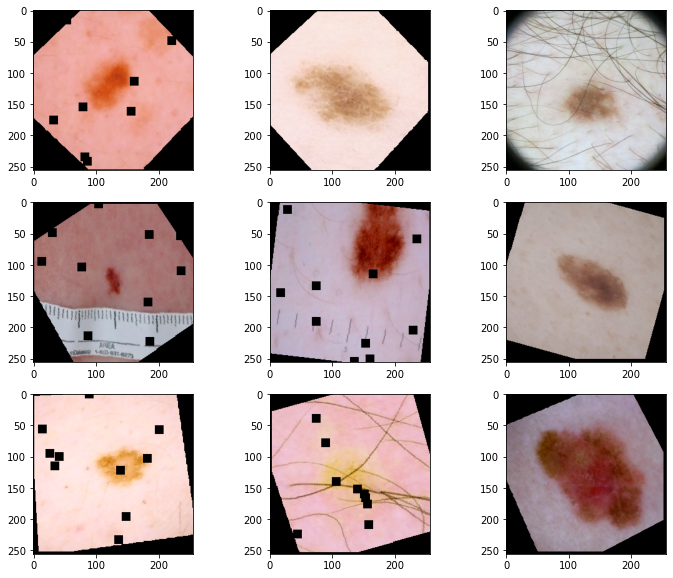

In [9]:
plt.figure(figsize=(12,10))
for idx,(img, _) in enumerate(data_loader(train_files, labelled=True, augment=True).unbatch().take(9)):
    plt.subplot(3,3,idx+1)
    plt.imshow(img.numpy())

In [10]:
# test training data loading pipeline 
for img_batch, label in data_loader(train_files, labelled=True, augment=True).take(1):
    print(img_batch.shape, label)
    

(256, 256, 256, 3) tf.Tensor(
[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1
 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1
 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1], shape=(256,), dtype=int64)


In [11]:
# test unlabelled data pipeline with return image name 
for img, img_name in data_loader(train_files, labelled=False, augment=True, return_image_names=True).unbatch().take(2):
    print(img.shape, img_name.numpy().decode("utf-8"))

(256, 256, 3) ISIC_0000446
(256, 256, 3) ISIC_0000138_downsampled


In [12]:
# test unlabelled data pipeline without return image name 
for img_batch in data_loader(train_files, labelled=False, augment=True, return_image_names=False).take(1):
    print(img_batch.shape)

(256, 256, 256, 3)


In [13]:
c=1
for img,label in data_loader(train_files[:2], labelled=True, shuffle=False, augment=False, repeat=False, ordered=True).unbatch():
    if c==1:
        print(img[2,3].numpy(),label.numpy())
    c+=1

[0.7764706 0.5568628 0.4117647] 1


# Model

In [14]:

def get_lr_callback(PLOT_LR = False): # LR scheduler
    lr_start   = 5e-6
    lr_max     = 1.4e-6 * BATCH_SIZE
    lr_min     =  1e-6
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if PLOT_LR:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot([lrfn(e) for e in range(EPOCHS)]);
        plt.xlabel('Epoch'); plt.ylabel('LR');
        plt.subplot(1, 2, 2);
        plt.plot([lrfn(e) for e in range(EPOCHS)]);
        plt.xlabel('Epoch'); plt.ylabel('Log LR');
        plt.yscale('log');

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

def build_model(input_shape = (192,192,3), pretrained_model= efn.EfficientNetB2, loss_type=LOSS_TYPE, opt = OPT_TYPE): 
    inp = tf.keras.layers.Input(shape=input_shape)
    base_model = pretrained_model(include_top=False, weights='imagenet', input_shape=input_shape)
    print("Using {} as the base model".format(base_model.name))
# weight freezing for Resnet50  
    if base_model.name == "resnet50":
        for layer in base_model.layers[:143]:
            layer.trainable = False   # freezing weights of deeper layers
        for layer in base_model.layers[143:]:
            layer.trainable = True   # fine-tuning last part of Resnet50
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs= inp, outputs = x)
    if OPT_TYPE == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate= LR)
    elif OPT_TYPE == "RAdam":
        optimizer =  tfa.optimizers.RectifiedAdam(lr=LR)
    if loss_type == 'BCE':
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
    elif loss_type == 'FOCAL':
        loss= tfa.losses.SigmoidFocalCrossEntropy(gamma = GAMMA, alpha = ALPHA)
    model.compile(optimizer= optimizer,loss= loss, metrics= ['AUC'])
    return model

In [15]:
build_model().summary()

31940608/31936256 [==============================] - 1s 0us/step
Using efficientnet-b2 as the base model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 6, 6, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               360704    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
______________________

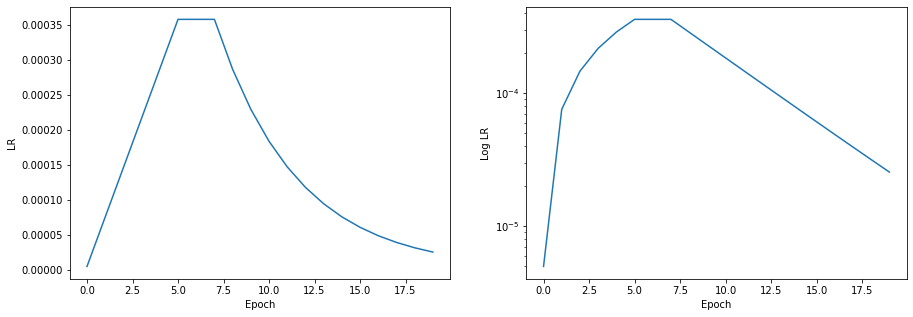

In [16]:
_ = get_lr_callback(PLOT_LR=True)

In [17]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [18]:
NUM_TEST_IMAGES = count_data_items(test_files)

def train_model(kfold_n_splits=5,train_set_aug=True, valid_set_aug=True,test_set_aug=True, pretrained_model= MobileNetV2, display_training_curve = True ):       

    preds = np.zeros(shape=(NUM_TEST_IMAGES,))
    oof_labels = []
    oof_preds = []
    kf = KFold(n_splits=kfold_n_splits,shuffle=True,random_state= 1357)
    if DEVICE=='TPU':
        print('using TPU')

    for fold,(idxT,idxV) in enumerate(kf.split(np.arange(15))):

        print('#'*25)
        print('### FOLD {}'.format(fold+1))
        print('#'*25)


        K.clear_session()
        with strategy.scope():
            model = build_model(input_shape = (DIM,DIM,3), pretrained_model = pretrained_model)
        train_tfrecords = tf.io.gfile.glob(["{}/train{:02d}-*.tfrec".format(GCS_PATH,i) for i in idxT])

        if INCLUDE_2018_DATA:
            train_tfrecords += tf.io.gfile.glob([f"{GCS_PATH_2019}/train{(2*x):02d}-*.tfrec" for x in range(15)])
        if INCLUDE_2019_DATA:
            train_tfrecords += tf.io.gfile.glob([f"{GCS_PATH_2019}/train{(2*x +1):02d}-*.tfrec" for x in range(14)])  
        if INCLUDE_CD_MALIGNANT:
            new_malignant_tfrecords = np.arange(15,30).tolist()
            train_tfrecords += tf.io.gfile.glob([f"{GCS_PATH_M}/train{x}-*.tfrec" for x in new_malignant_tfrecords])
        if UPSAMPLE:
            train_tfrecords += tf.io.gfile.glob([f"{GCS_PATH_M}/train{x:02d}-*.tfrec" for x in idxT])
        
        np.random.shuffle(train_tfrecords) # shuffle the tfrecord files
        val_tfrecords = tf.io.gfile.glob(["{}/train{:02d}-*.tfrec".format(GCS_PATH,i) for i in idxV])

        train_dataset = data_loader(train_tfrecords, labelled=True, augment=train_set_aug, repeat=True, shuffle=True, ordered=False)
        valid_dataset = data_loader(val_tfrecords, labelled = True, augment=False, repeat=False, shuffle=False, ordered=False)

        NUM_TRAINING_IMAGES = count_data_items(train_tfrecords)
        NUM_VALIDATION_IMAGES = count_data_items(val_tfrecords)


        model_best_epoch = tf.keras.callbacks.ModelCheckpoint(
            "fold{}.h5".format(fold+1), monitor='val_auc', verbose=1, save_best_only=True,
            save_weights_only=True, mode='max', save_freq='epoch')

        history = model.fit(train_dataset,epochs = EPOCHS,  #class_weight = {0: weight_for_0, 1: (weight_for_1)/2},
                            steps_per_epoch= np.ceil(NUM_TRAINING_IMAGES/BATCH_SIZE),
                            verbose= 1, callbacks=[model_best_epoch, get_lr_callback()],validation_data = valid_dataset)

        print("#"*5+" Loading model weights from best epoch "+"#"*5)
        model.load_weights("fold{}.h5".format(fold+1))

        if valid_set_aug:
            print(f"### With validation set augmentation size = {TTA} ###")
            valid_dataset_tta = data_loader(val_tfrecords,  labelled=True, augment=True, shuffle=False, repeat=True)
            valid_images = valid_dataset_tta.map(lambda image, label: image)
            ypred_valid = model.predict(valid_images, steps = np.ceil(TTA*NUM_VALIDATION_IMAGES/BATCH_SIZE), verbose=1)
            ypred_valid = ypred_valid[:NUM_VALIDATION_IMAGES * TTA].reshape((NUM_VALIDATION_IMAGES,TTA), order = 'F') # Fortran like indexing, augmentations in columns
            ypred_valid = ypred_valid.mean(axis = 1) # take the average across number of augmentations
        else:
            print('#'*5+" Without validation set augmentation "+'#'*5)
            valid_dataset_no_tta = data_loader(val_tfrecords, labelled=True, augment=False,  shuffle=False,repeat=False)
            valid_images = valid_dataset_no_tta.map(lambda image, label: image)
            ypred_valid = model.predict(valid_images,steps = NUM_VALIDATION_IMAGES/BATCH_SIZE, verbose =1)

        valid_labels = np.array([label.numpy() for label in data_loader(val_tfrecords, labelled=True, augment=False,  shuffle=False,repeat=False).map(lambda image, label: label).unbatch()] )
        auc_valid = roc_auc_score(valid_labels, ypred_valid)        
        print(f'AUC of validation fold {fold+1} (with TTA = {TTA}) = {auc_valid}')
        oof_labels.append(valid_labels)
        oof_preds.append(ypred_valid)

        if test_set_aug:
            print(f"### Using test set augmentation with TTA = {TTA} ###")
            test_data = data_loader(test_files, labelled=False, augment=True, shuffle=False, repeat=True, return_image_names=False, batch_size = BATCH_SIZE*8)
            ypred_test = model.predict(test_data, steps = TTA*NUM_TEST_IMAGES/(BATCH_SIZE*8), verbose=1)
            ypred_test = ypred_test[:NUM_TEST_IMAGES * TTA].reshape((NUM_TEST_IMAGES,TTA), order = 'F') # Fortran like indexin
            ypred_test = ypred_test.mean(axis = 1) 
        else:
            print("### Without test set augmentation ###")
            test_data = data_loader(test_files, labelled=False, augment=False, shuffle=False, repeat=False, return_image_names=False)
            ypred_test = model.predict(test_data, verbose=1)
        preds += (ypred_test/kfold_n_splits)

        if display_training_curve:
            print("Fold: {}".format(fold+1))
            display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
            display_training_curves(history.history['auc'], history.history['val_auc'], 'AUC', 212)
            
    return preds, oof_labels,oof_preds

using TPU
#########################
### FOLD 1
#########################
Using efficientnet-b2 as the base model
Epoch 1/20
202/202 [==============================] - ETA: 0s - auc: 0.5600 - loss: 0.0635
Epoch 00001: val_auc improved from -inf to 0.45420, saving model to fold1.h5
202/202 [==============================] - 59s 292ms/step - auc: 0.5600 - loss: 0.0635 - val_auc: 0.4542 - val_loss: 0.0518 - lr: 5.0000e-06
Epoch 2/20
202/202 [==============================] - ETA: 0s - auc: 0.7500 - loss: 0.0381
Epoch 00002: val_auc improved from 0.45420 to 0.79755, saving model to fold1.h5
202/202 [==============================] - 41s 203ms/step - auc: 0.7500 - loss: 0.0381 - val_auc: 0.7975 - val_loss: 0.0123 - lr: 7.5680e-05
Epoch 3/20
202/202 [==============================] - ETA: 0s - auc: 0.7837 - loss: 0.0366
Epoch 00003: val_auc improved from 0.79755 to 0.86558, saving model to fold1.h5
202/202 [==============================] - 42s 206ms/step - auc: 0.7837 - loss: 0.0366 - val_au

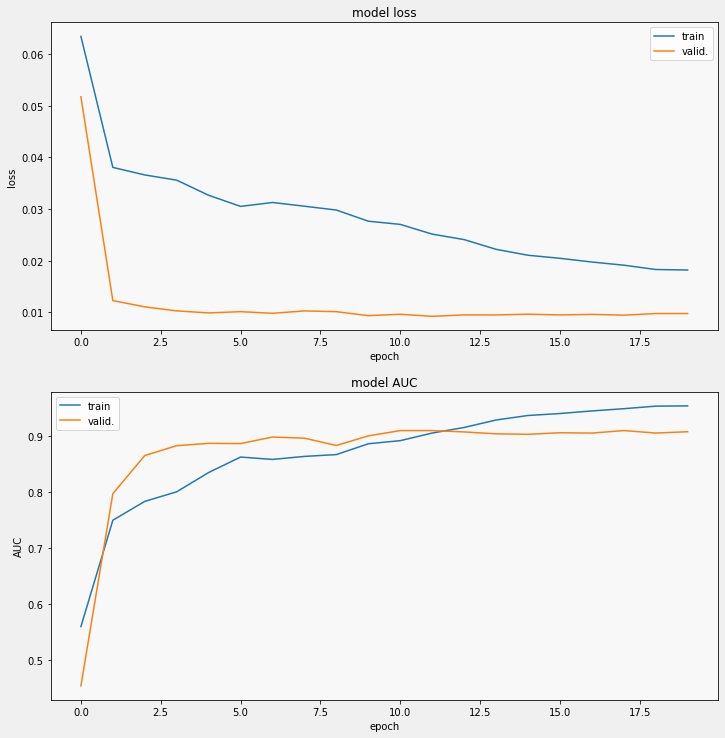

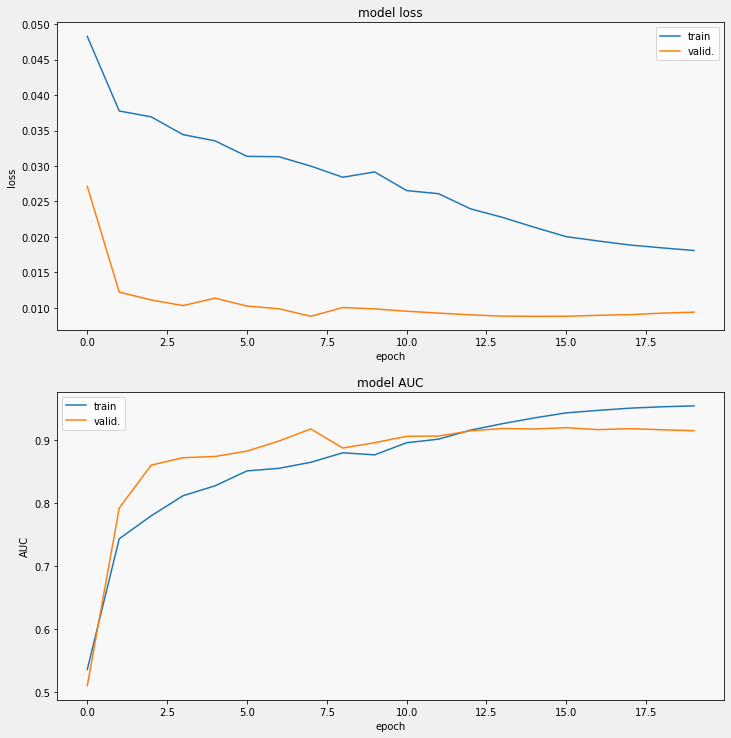

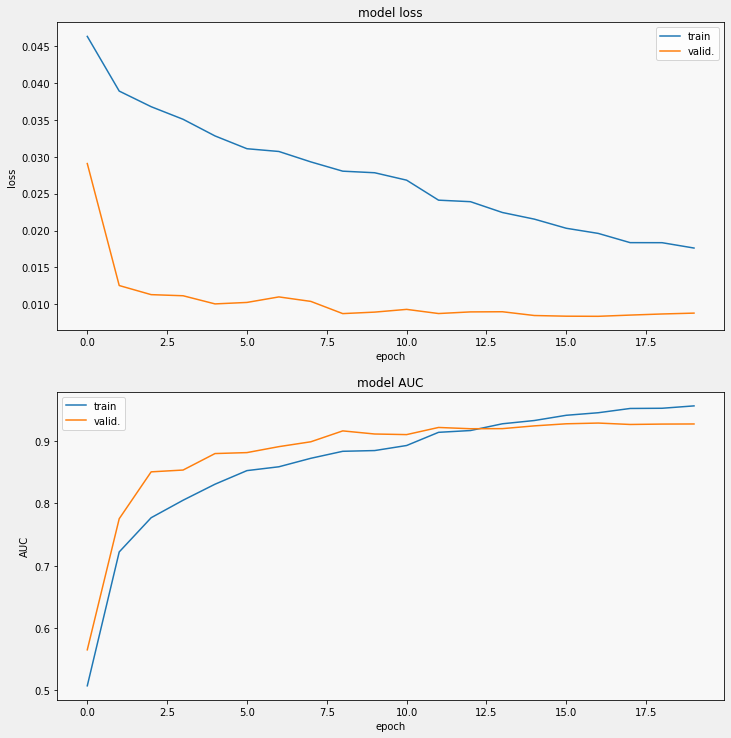

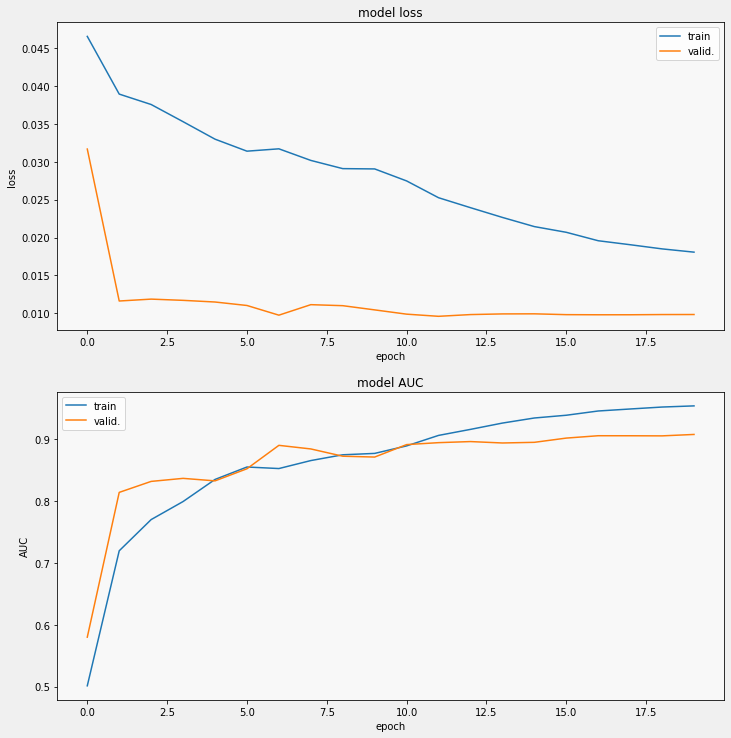

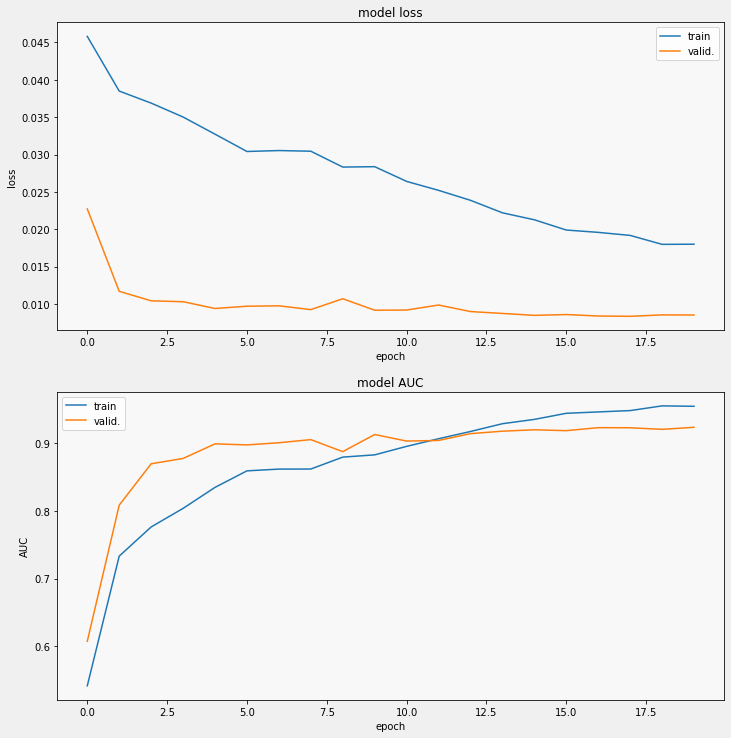

In [19]:
pretrained_model = efn.EfficientNetB2

preds, oof_labels,oof_preds =  train_model(train_set_aug=True,pretrained_model = pretrained_model, display_training_curve=True)

In [20]:
print(np.concatenate(oof_preds).shape)

(32692,)


In [21]:
# Out-of-fold AUC score on the full 2020 training data (with TTA if applicable)
roc_auc_score(np.concatenate(oof_labels),np.concatenate(oof_preds))

0.9224644655846591

In [22]:
# Get image names in the test set
test_img_names = []
test_dataset = data_loader(test_files, labelled=False, augment=False, shuffle=False, repeat=False, return_image_names=True, ordered=True)
for _,image_name in test_dataset.unbatch():
    test_img_names.append(image_name.numpy().decode("utf-8"))
    
sample_sub = pd.read_csv(DATA_PATH+'/sample_submission.csv')
sample_sub.loc[:,'image_name' ] = test_img_names
sample_sub.loc[:,'target' ] = preds

# submit 
sample_sub.to_csv("submission.csv",index=False)

In [23]:
sample_sub.sort_values('image_name').head()

,image_name,target
9905,ISIC_0052060,0.044750
1443,ISIC_0052349,0.069361
3120,ISIC_0058510,0.018036
4870,ISIC_0073313,0.032152
5494,ISIC_0073502,0.065345
